In [1]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import eigsh

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))

# Verifique se os caminhos foram adicionados
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_pre_processing import read_mesh
    from fem_processing import boundary_conditions
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!
Modules imports were successful!
Modules imports were successful!


# Project 3: Rectangular Guide

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
### Geometry and mesh Domain

In [2]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Neumann', 'value': 0.0, 'name': 'Ez_0'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

# Create mesh from file geometry
ps.create_mesh_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=1E-3, view_mesh=False)
mesh_data = read_mesh.get_data(FINITE_ELEMENT, BOUNDARY, MATERIAL, model='rectangular_guide')

Model rectangular_guide_domain_Triangle1 (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 3828 nodes in total
Info     : 7414 2-D elements in total


## `apply_boundary_conditions()`

In [3]:
mesh_data = ps.apply_physics(FINITE_ELEMENT, mesh_data); mesh_data['cell'][1]

{'Tag': 245,
 'conn': [301, 2094, 3736],
 'material': {'tag': 201,
  'name': 'free_space',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1},
 'stiffness_a_value': 1,
 'mass_a_value': 1,
 'abc': {'type': None, 'conn_idx': None},
 'source': {'type': 'free_source', 'value': 0}}

In [4]:
mesh_data['nodes'][1]

{'xg': (0.0, 0.0), 'bc': {'type': 'Neumann', 'value': 0.0}}

## `apply_physics()`

In [5]:
graph_results.plot_mesh(FINITE_ELEMENT, mesh_data, model='rectangular_guide', Numbering=False)

Arquivo salvo em: c:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p31_rectangular_guide\pre_processing\pictures\rectangular_guide_meshed_domain_Triangle1.svg


<figure>
    <img src="pre_processing/pictures/rectangular_guide_meshed_domain_Triangle1.svg" alt="Fig.1" style="width:100%;" />
    <figcaption>Figure 1: Rectangular meshed domain $\Omega=[0,1]^2$.</figcaption>
</figure>

## Imposition of Boundary Conditions

In [6]:
dirichlet_nodes = {key: value 
                   for key, value in mesh_data['nodes'].items() if value['bc']['type'] == 'Dirichlet'}

In [7]:
Nn = len(mesh_data['nodes']); Nd = len(dirichlet_nodes)
print(f"The entire domain has {Nn} nodes: {Nn - Nd} free nodes; {Nd} Dirichlet nodes.")

The entire domain has 3828 nodes: 3828 free nodes; 0 Dirichlet nodes.


## Processor Module

### Reduced Global matrix $A_{gr}$ with boundary conditions

In [8]:
Agr, fgr, Mgr, Pgr, Qgr = boundary_conditions.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
print("Reduced global matrix shape:", Agr.shape)

Reduced global matrix shape: (3828, 3828)


## Eigenvalue Problem

In [9]:
# Resolver o problema de autovalor generalizado
# k Número de autovalores/autovetores desejados
eigenvalues, eigenvectors = eigsh(Agr, k=6, M=Mgr, which='SM')
print("Eigenvector shape:", eigenvectors.shape)

# Definir um limiar para eliminar erros de truncamento
threshold = 1e-8
positive_indices = np.where(eigenvalues > threshold)[0]

# Filtrar autovalores positivos e ordenar
sorted_positive_eigenvalues = eigenvalues[positive_indices]
sorted_positive_eigenvectors = eigenvectors[:, positive_indices]

# Ordenar os autovalores positivos e ajustar os autovetores na mesma ordem
sorted_indices = np.argsort(sorted_positive_eigenvalues)
sorted_positive_eigenvalues = sorted_positive_eigenvalues[sorted_indices]
sorted_positive_eigenvectors = sorted_positive_eigenvectors[:, sorted_indices]

# Resultados
print("Menores autovalores positivos:")
print(sorted_positive_eigenvalues)

print("\nAutovetores correspondentes (colunas correspondem aos autovalores):")
print(sorted_positive_eigenvectors)

Eigenvector shape: (3828, 6)
Menores autovalores positivos:
[ 1542.27309518  6170.86632339  6170.90529276  7714.38126146
 12346.53832047]

Autovetores correspondentes (colunas correspondem aos autovalores):
[[ -2.27557068+24.89963262j  20.94609416+12.42944263j
    5.40323388+25.07837769j  -5.26193294+34.98586699j
   34.86433831 +6.09779429j]
 [  2.27556921-24.89961644j  20.94594302+12.42935294j
    5.40334368+25.0788873j    5.26197944-34.98617621j
   34.86526021 +6.09795553j]
 [  2.27557959-24.89973009j  22.06253129+13.09193779j
   -5.13007381-23.81054196j  -5.26206714+34.98675932j
  -34.86604247 -6.09809235j]
 ...
 [ -2.265902  +24.7938364j   20.87028985+12.38446018j
    2.67514073+12.41630315j  -2.52774967+16.80665922j
   16.53428015 +2.8918558j ]
 [  2.26618713-24.79695641j  21.03952241+12.48488299j
    1.17859975 +5.47031109j   1.03895822 -6.90789j
    6.79901644 +1.18915217j]
 [ -2.25709087+24.69742369j  20.2742984 +12.03079805j
    5.17426058+24.01562916j  -4.99667136+33.22217929

# Modos analíticos

In [10]:
te_modes = ps.waveguide_modes(m_max=5, n_max=5, mode_type='TE')


Cinco menores autovalores analíticos dos modos TE:
TE_10: kc2 = 1542.126 rad2/m2
TE_01: kc2 = 6168.503 rad2/m2
TE_20: kc2 = 6168.503 rad2/m2
TE_11: kc2 = 7710.628 rad2/m2
TE_21: kc2 = 12337.006 rad2/m2


# `calculate_error()`

In [11]:
ps.calculate_error(te_modes, sorted_positive_eigenvalues)

Modo TE_10: Erro percentual = 0.0096
Modo TE_01: Erro percentual = 0.0383
Modo TE_20: Erro percentual = 0.0389
Modo TE_11: Erro percentual = 0.0487
Modo TE_21: Erro percentual = 0.0773


# `Graphs()`

C:\Users\adilt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\tri\_tricontour.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z_check.max())
C:\Users\adilt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\tri\_tricontour.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z_check.min())
C:\Users\adilt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\tri\_tricontour.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  C = _tri.TriContourGenerator(tri.get_cpp_triangulation(), z)


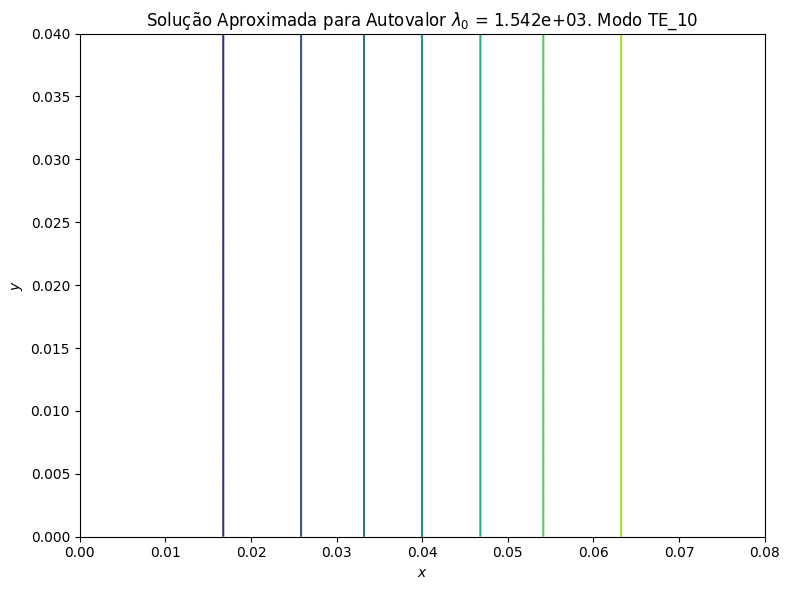

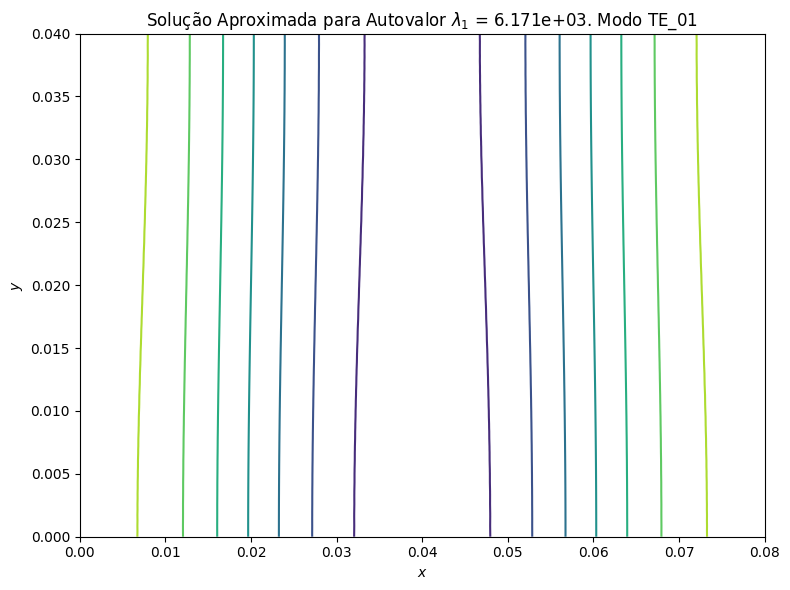

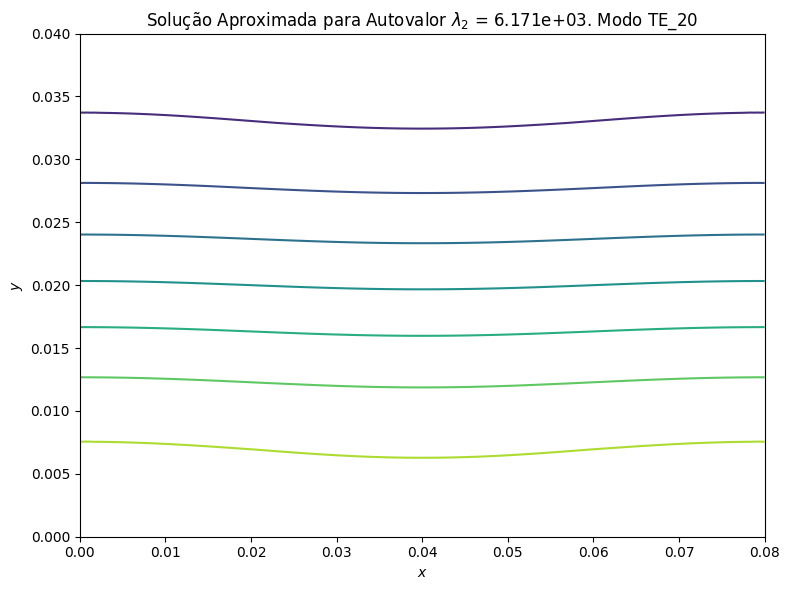

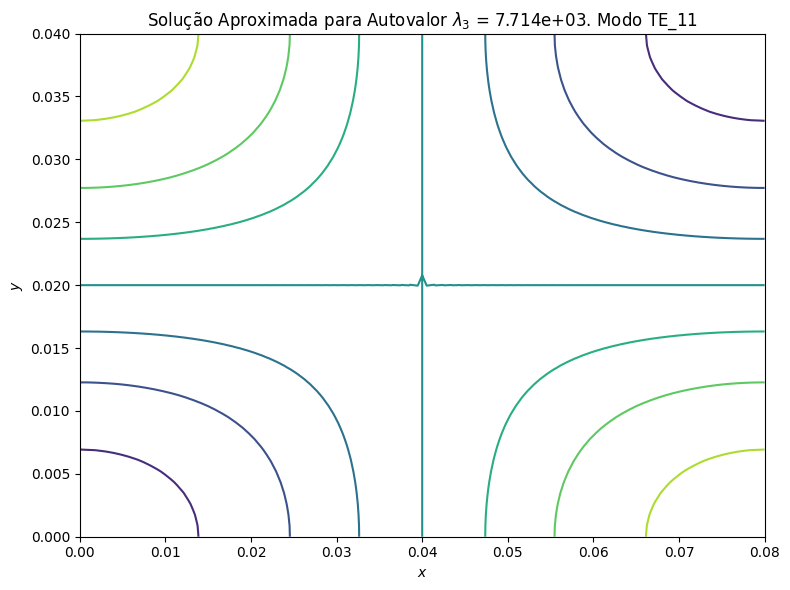

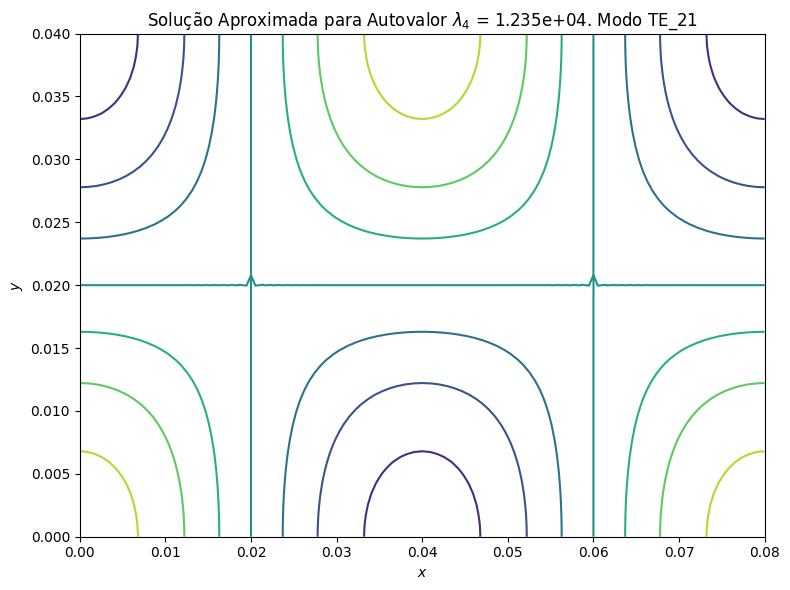

In [12]:
ps.get_modes_pattern(mesh_data, sorted_positive_eigenvalues, sorted_positive_eigenvectors, te_modes)

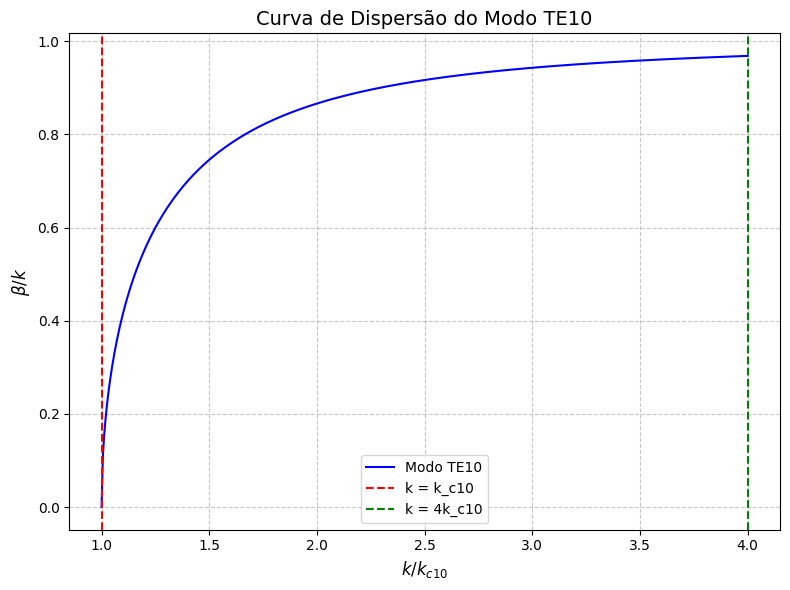

In [13]:
import matplotlib.pyplot as plt
from scipy.constants import c, mu_0, epsilon_0

# Constante de corte do modo TE10 (1/m)
kc_10 = np.sqrt(sorted_positive_eigenvalues[0])   # Constante de onda de corte do modo TE10 (1/m)

# Varredura de k
k = np.linspace(1 * kc_10, 4 * kc_10, 500)  # Evita k=0 para evitar divisão por zero

# Cálculo da dispersão para o modo TE10
beta = np.sqrt(k**2 - kc_10**2)  

# Normalização
k_normalized = k / kc_10
beta_normalized = beta / k

# Plota o gráfico de dispersão
plt.figure(figsize=(8, 6))
plt.plot(k_normalized, beta_normalized, label="Modo TE10", color="blue")

# Destaque da faixa de operação monomodo
plt.axvline(1, color="red", linestyle="--", label="k = k_c10")
plt.axvline(4, color="green", linestyle="--", label='k = 4k_c10')

# Configurações do gráfico
plt.xlabel(r"$k/k_{c10}$", fontsize=12)
plt.ylabel(r"$\beta/k$", fontsize=12)
plt.title("Curva de Dispersão do Modo TE10", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()

# Mostra o gráfico
plt.show()

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.